In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# to read the data
import pandas as pd

1. Choose two simple dataset of binary classification, these datasets data must be with classes that are separated linearly
with a bit of noise, one which is 2 D and the other 3 D 

In [2]:
# read the data from csv file
twod_data = pd.read_csv('2d_noise_data.csv')
threed_data = pd.read_csv('3d_noise_data.csv')

In [3]:
# extract the features and labels
X_two_d = twod_data.iloc[:, [0, 1]].values
y_two_d = twod_data.iloc[:, 2].values

X_three_d = threed_data.iloc[:, [0, 1, 2]].values
y_three_d = threed_data.iloc[:, 3].values

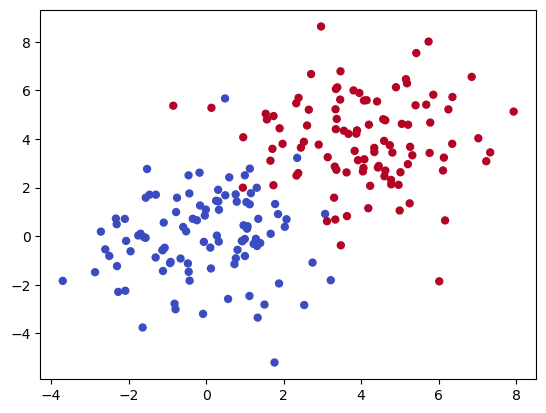

In [4]:
# Visualising the 2d data 
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)
plt.show()

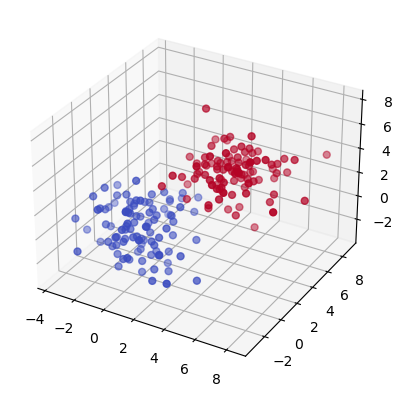

In [5]:
# Visualising the 3d data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_three_d[:, 0], X_three_d[:, 1], X_three_d[:, 2], c=y_three_d, cmap=plt.cm.coolwarm, s=25)
plt.show()  

3. Split data into train and test

In [6]:
# first we shuffle the data using numpy

# shuffle the 2d data 
np.random.seed(0)
shuffle_index = np.random.permutation(len(X_two_d))
X_two_d, y_two_d = X_two_d[shuffle_index], y_two_d[shuffle_index]

# shuffle the 3d data
np.random.seed(0)
shuffle_index = np.random.permutation(len(X_three_d))
X_three_d, y_three_d = X_three_d[shuffle_index], y_three_d[shuffle_index]

In [7]:
# split the data into training and testing 0.8:0.2
X_train_two_d, X_test_two_d = X_two_d[:80], X_two_d[80:]
y_train_two_d, y_test_two_d = y_two_d[:80], y_two_d[80:]

X_train_three_d, X_test_three_d = X_three_d[:80], X_three_d[80:]
y_train_three_d, y_test_three_d = y_three_d[:80], y_three_d[80:]

4-5 Implement the SMO optimization algorithm with Soft Margin SVC and Hard Margin SVC

to implement the Hard margin SVC it is enough to take a very big value for C

In [8]:
def K(x1, x2):
    """
    description:
        calculate the kernel value of x1 and x2
    args:
        x1: a data point
        x2: a data point
    returns:
        the kernel value of x1 and x2
    """
    return x1.dot(x2.T)

#### stopping criteria 2 ####
def stopping_criteria2(alphas, Y, X, H, C, eps):
    """
    description:
        stopping criteria 2 for SMO algorithm
    args:
        alphas: the alpha values
        Y: the labels
        C: the regularization parameter
        eps: the tolerance
    returns:
        True if stopping criteria 2 is satisfied, False otherwise
    """
    l = len(alphas) # number of data points
    e = np.ones(l) # vector of ones
    delta_d = lambda alpha, H: np.dot(H, alpha) - e # delta_d function

    Iup, Ilow = [], [] # initialize the indices of the working set B
    for i in range(l):
        if (alphas[i] < C and Y[i] == 1) or (alphas[i] > 0 and Y[i] == -1): # if the point is in the upper set
            Iup.append(i)
        if (alphas[i] > 0 and Y[i] == 1) or (alphas[i] < C and Y[i] == -1): # if the point is in the lower set 
            Ilow.append(i)

    D = delta_d(alphas, H) # calculate delta_d
    d_up = [-Y[i] * D[i] for i in Iup] # calculate d_up for each point in the upper set
    d_low = [-Y[i] * D[i] for i in Ilow] # calculate d_low for each point in the lower set

    M, m = min(d_low), max(d_up) # calculate M and m
    if m - M <= eps: # if stopping criteria 2 is satisfied
        return True
    return False

#### selecting working set B ####
def selectB(alphas, Y, H, C):
    """
    description:
        select the working set B
    args:   
        alphas: the alpha values
        Y: the labels
        H: the Hessian matrix
        C: the regularization parameter
    returns:
        the indices of the working set B
    """
    l = len(alphas) # number of data points
    e = np.ones(l) # vector of ones
    delta_d = lambda alpha, H: np.dot(H, alpha) - e # delta_d function 
    D = delta_d(alphas, H) # calculate delta_d

    Iup, Ilow = [], [] # initialize the indices of the working set B
    for t in range(l): # loop over the data points
        if (alphas[t] < C and Y[t] == 1) or (alphas[t] > 0 and Y[t] == -1): # if the point is in the upper set
            Iup.append(t)
        if (alphas[t] > 0 and Y[t] == 1) or (alphas[t] < C and Y[t] == -1): # if the point is in the lower set
            Ilow.append(t)

    d_up = np.array([(Y[i] * D[i], i) for i in Iup]) # calculate d_up for each point in the upper set
    d_low = np.array([(Y[i] * D[i], i) for i in Ilow]) # calculate d_low for each point in the lower set

    # return the indices of max d_up and min d_low
    return int(d_up[d_up[:, 0].argmax()][1]), int(d_low[d_low[:, 0].argmin()][1])

#### solving the 2-variable subproblem ####
def solve_subproblem(alphas, X, Y, C, i, j, eps):
    """
    description:
        solve the 2-variable subproblem
    args:
        alphas : the alpha values 
        X : the data
        Y : the labels
        C : the regularization parameter
        i : the index of the first variable
        j : the index of the second variable
        eps : the tolerance
    returns:
        the new alpha values
    """
    if i == j: # if i == j, return 0
        return (0, 0)
    
    l = X.shape[0] # number of data points
    a1_old, a2_old = alphas[i], alphas[j] # save the old values
    
    if Y[i] != Y[j]: # if the labels are different
        U = max(0, a2_old - a1_old)
        V = min(C, C + a2_old - a1_old)
    else: # if the labels are the same
        U = max(0, a1_old + a2_old - C)
        V = min(C, a1_old + a2_old)

    if U == V: # if U == V, return 0
        return (0, 0)

    b11, b12, b22 = K(X[i], X[i]), K(X[i], X[j]), K(X[j], X[j]) # calculate the kernel values
    eta = b11 + b22 - 2 * b12 # calculate eta value 

    if eta > 0: # if eta > 0
        b1 = sum([Y[t] * alphas[t] * K(X[t], X[0]) for t in range(l) if (t != j and t != i)]) # calculate b1 and b2
        b2 = sum([Y[t] * alphas[t] * K(X[t], X[1]) for t in range(l) if (t != j and t != i)])
        E = b1 - b2 + a1_old * Y[i] * (b11 - b12) + a2_old * Y[j] * (b12 - b22) - Y[i] + Y[j] # calculate the error

        a2_new = a2_old + (Y[j] * E )/ eta # calculate the new alpha values
        if a2_new > V: # clip the values
            a2_new = V
        elif a2_new < U: 
            a2_new = U
    else: 
        f1 = Y[i] * (a1_old - a2_old) * b11 + Y[j] * a2_old * b12 + Y[i] * a1_old - 1 # calculate the objective function values
        f2 = Y[i] * (a1_old - a2_old) * b12 + Y[j] * a2_old * b22 + Y[j] * a2_old - 1
        Lobj = U * f1 + U * U * f2 / 2 
        Hobj = V * f1 + V * V * f2 / 2 
        if Lobj < Hobj - eps: # clip the values
            a2_new = U
        elif Lobj > Hobj + eps:
            a2_new = V
        else:
            a2_new = a2_old
    
    if abs(a2_new - a2_old) < eps * (a2_new + a2_old + eps): # if the change is too small, return 0
        return (0, 0)

    a1_new = a1_old + Y[i] * Y[j] * (a2_old - a2_new) # calculate the new alpha values
    return (a1_new, a2_new)

#### SMO algorithm ####
def SMO(X, Y, C, eps, max_iter=1000):
    """
    description:
        SMO algorithm for SVM
    args:
        X: the data
        Y: the labels
        C: the regularization parameter
        eps: the tolerance
        max_iter: the maximum number of iterations
    returns:
        alphas: the alpha values
    """
    l = X.shape[0] # the number of data points
    alphas = np.zeros(l) # initialize the alpha values
    H = np.dot(np.dot(Y.T, Y), K(X, X)) # the Hessian matrix
    iter = 0 # the iteration number
    while iter < max_iter: 
        i, j = selectB(alphas, Y, H, C) # select the working set B
        a1_new, a2_new = solve_subproblem(alphas, X, Y, C, i, j, eps=eps) # solve the 2-variable subproblem
        alphas[i], alphas[j] = a1_new, a2_new # update the alpha values
        if stopping_criteria2(alphas, Y, X, H, C, eps=eps): 
            break # stopping criteria
        iter += 1
        if iter%100 == 0 : print("\riter: ", iter) # print the iteration number
    return alphas

#### C-SVM algorithm ####
def C_SVM(X, Y, C, eps, max_iter=100):
    """
    description:
        C-SVM algorithm
    args:
        X: the data
        Y: the labels
        C: the regularization parameter
        eps: the tolerance
        max_iter: the maximum number of iterations
    returns:
        w: the weight vector
        b: the bias
    """
    alphas = SMO(X, Y, C, eps, max_iter) # run SMO algorithm to get the alpha values
    w, b = None, None # initialize the weight vector and the bias
    for j in range(len(alphas)): # compute the weight vector and the bias
        if alphas[j] > 0 and alphas[j] < C: # find the support vector
            w = np.sum([alphas[t] * Y[t] * X[t] for t in range(len(alphas))], axis=0) # compute the weight vector
            b = Y[j] - np.sum([alphas[t] * Y[t] * K(X[t], X[j]) for t in range(len(alphas))]) # compute the bias
            break
    return w, b

### Soft Margin SVC

2D Data

In [9]:
soft_alpha_two_d, soft_b_two_d = C_SVM(X_train_two_d, y_train_two_d, C=1, eps=1e-5, max_iter=1000)

iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000


In [10]:
# compute the predictions
soft_y_pred_two_d = np.sign(np.dot(X_test_two_d, soft_alpha_two_d) + soft_b_two_d)

In [11]:
# calculate the accuracy
accuracy_two_d = np.mean(soft_y_pred_two_d == y_test_two_d)

print('Accuracy of Soft Margin SVC in the 2D data : {:.2f} %'.format(accuracy_two_d* 100))

Accuracy of Soft Margin SVC in the 2D data : 91.67 %


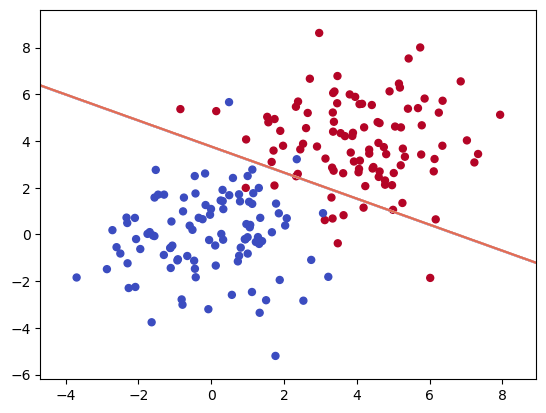

In [12]:
# visualize the decision boundary
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)

# plot the decision boundary
x_min, x_max = X_two_d[:, 0].min() - 1, X_two_d[:, 0].max() + 1
y_min, y_max = X_two_d[:, 1].min() - 1, X_two_d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = np.dot(np.c_[xx.ravel(), yy.ravel()], soft_alpha_two_d) + soft_b_two_d
Z = np.sign(Z).reshape(xx.shape)

plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.show()

3D Data

In [13]:
soft_alpha_three_d, soft_b_three_d = C_SVM(X_train_three_d, y_train_three_d, C=1, eps=1e-5, max_iter=1000)

iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000


In [14]:
# compute the predictions
soft_y_pred_three_d = np.sign(np.dot(X_test_three_d, soft_alpha_three_d) + soft_b_three_d)

In [15]:
# calculate the accuracy
accuracy_three_d = np.mean(soft_y_pred_three_d == y_test_three_d)

print('Accuracy of Soft Margin SVC in the 3D data : {:.2f} %'.format(accuracy_three_d* 100))

Accuracy of Soft Margin SVC in the 3D data : 97.50 %


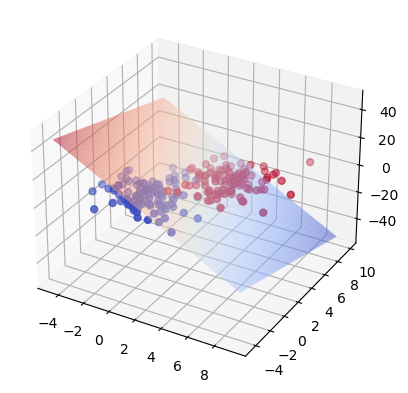

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_three_d[:, 0], X_three_d[:, 1], X_three_d[:, 2], c=y_three_d, cmap=plt.cm.coolwarm, s=25)

# plot the hyperplan decision boundary
x_min, x_max = X_three_d[:, 0].min() - 1, X_three_d[:, 0].max() + 1
y_min, y_max = X_three_d[:, 1].min() - 1, X_three_d[:, 1].max() + 1
z_min, z_max = X_three_d[:, 2].min() - 1, X_three_d[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = (-soft_b_three_d - soft_alpha_three_d[0] * xx - soft_alpha_three_d[1] * yy) / soft_alpha_three_d[2]

ax.plot_surface(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.show()


### Hard Margin SVC

In [17]:
hard_alpha_two_d, hard_b_two_d = C_SVM(X_train_two_d, y_train_two_d, C=1e10, eps=1e-5, max_iter=1000)

iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000


In [18]:
# compute the predictions
hard_y_pred_two_d = np.sign(np.dot(X_test_two_d, hard_alpha_two_d) + hard_b_two_d)

In [19]:
# calculate the accuracy
accuracy_two_d = np.mean(hard_y_pred_two_d == y_test_two_d)

print('Accuracy of Hard Margin SVC in the 2D data : {:.2f} %'.format(accuracy_two_d* 100))

Accuracy of Hard Margin SVC in the 2D data : 91.67 %


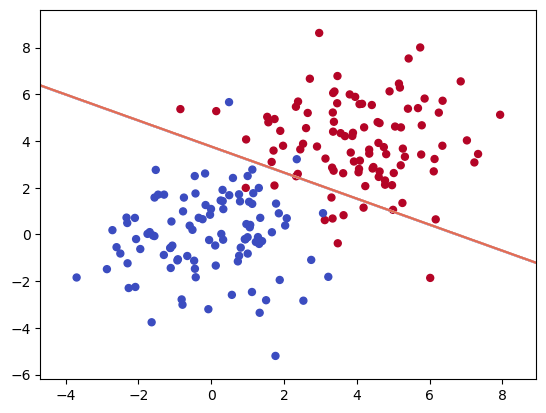

In [20]:
# visualize the decision boundary
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)

# plot the decision boundary
x_min, x_max = X_two_d[:, 0].min() - 1, X_two_d[:, 0].max() + 1
y_min, y_max = X_two_d[:, 1].min() - 1, X_two_d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
# plot the line with the learned 
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], hard_alpha_two_d) + hard_b_two_d
Z = np.sign(Z).reshape(xx.shape)

plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.show()


### 3D Data

In [21]:
hard_alpha_three_d, hard_b_three_d = C_SVM(X_train_three_d, y_train_three_d, C=1e10, eps=1e-5, max_iter=1000)

iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000


In [22]:
# compute the predictions
hard_y_pred_three_d = np.sign(np.dot(X_test_three_d, hard_alpha_three_d) + hard_b_three_d)

In [23]:
# calculate the accuracy
accuracy_three_d = np.mean(hard_y_pred_three_d == y_test_three_d)

print('Accuracy of Hard Margin SVC in the 3D data : {:.2f} %'.format(accuracy_three_d* 100))

Accuracy of Hard Margin SVC in the 3D data : 97.50 %
